Loads the QuickDraw dataset. Demonstrates reading the original files, working with the data as a sequence of strokes, and converting those strokes to images. Also writes a dataset to disk in a convenient format.

In [1]:
from __future__ import print_function

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import functools, itertools, json, os, re, textwrap
import tensorflow as tf

from PIL import Image, ImageDraw
from six.moves.urllib import request
from xml.dom import minidom

# Get the data

In [2]:
# Retrieve list of classes.

def list_bucket(bucket, regexp='.*'):
    """Returns a (filtered) list of Keys in specified GCE bucket."""
    keys = []
    fh = request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')
print('available: (%d)' % len(all_ndjsons))
print('\n'.join(textwrap.wrap(
    ' '.join([key.split('/')[-1].split('.')[0] for key in all_ndjsons]),
    width=100)))

available: (309)
The Eiffel Tower The Great Wall of China The Mona Lisa aircraft carrier airplane alarm clock
ambulance angel animal migration ant anvil apple arm asparagus axe backpack banana bandage barn
baseball bat baseball basket basketball bat bathtub beach bear beard bed bee belt bench bicycle
binoculars bird birthday cake blackberry blueberry book boomerang bottlecap bowtie bracelet brain
bread bridge broccoli broom bucket bulldozer bus bush butterfly cactus cake calculator calendar
camel camera camouflage campfire candle cannon canoe car carrot castle cat ceiling fan cell phone
cello chair chandelier church circle clarinet clock cloud coffee cup compass computer cookie cooler
couch cow crab crayon crocodile crown cruise ship cup diamond dishwasher diving board dog dolphin
donut door dragon dresser drill drums duck dumbbell ear elbow elephant envelope eraser eye
eyeglasses face fan feather fence finger fire hydrant fireplace firetruck fish flamingo flashlight
flip flops floor l

In [4]:
# Store all data locally in this directory.
data_path = 'data'
if not os.path.exists(data_path): 
  os.mkdir(data_path)

# Mini group of two animals.
pets = ['cat', 'dog']

# Somewhat larger group of zoo animals.
zoo = ['elephant', 'giraffe', 'kangaroo', 'lion', 'monkey', 'panda',
       'penguin', 'rhinoceros', 'tiger', 'zebra']

# Even larger group of all animals.
animals = ['bat', 'bird', 'butterfly', 'camel', 'cat', 'cow', 'crab',
           'crocodile', 'dog', 'dolphin', 'duck', 'elephant', 'fish',
           'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl',
           'panda', 'parrot', 'penguin', 'pig', 'rabbit', 'raccoon',
           'rhinoceros', 'scorpion', 'sea turtle', 'shark', 'sheep',
           'snail', 'spider', 'squirrel', 'teddy-bear', 'tiger',
           'whale', 'zebra']

# Create your own group -- the more classes you include the more challenging
# the classification task will be...

# Choose one of the above groups.
# Note: This will result in ~100MB of download per class.
classes, classes_name = animals, 'animals'

In [5]:
# Download the chosen group.

def valid_ndjson(filename):
    """Checks presence + completeness of .ndjson file."""
    try:
        json.loads(open(filename).readlines()[-1])
        return True
    except (ValueError, IOError):
        return False

def retrieve(bucket, key, filename):
    """Returns a file specified by its Key from a GCE bucket."""
    url = 'https://storage.googleapis.com/%s/%s' % (bucket, key)
    if not os.path.isfile(filename):
        request.urlretrieve(url=url, filename=filename)
    while not valid_ndjson(filename):
        print('*** Corrupted download (%.2f MB), retrying...' % (os.path.getsize(filename) / 2.**20))
        request.urlretrieve(url=url, filename=filename)

if not os.path.exists(data_path):
    os.mkdir(data_path)

print('\n%d classes:' % len(classes))

for name in classes:
    print(name, end=' ')
    dst = '%s/%s.ndjson' % (data_path, name)
    retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
    print('%.2f MB' % (os.path.getsize(dst) / 2.**20))

print('\nDONE :)')



43 classes:
bat 58.02 MB
bird 65.86 MB
butterfly 63.27 MB
camel 54.31 MB
cat 73.12 MB
cow 91.94 MB
crab 76.46 MB
crocodile 57.19 MB
dog 87.06 MB
dolphin 46.29 MB
duck 67.93 MB
elephant 70.86 MB
fish 48.59 MB
frog 92.50 MB
giraffe 58.27 MB
hedgehog 90.76 MB
horse 99.79 MB
kangaroo 96.06 MB
lion 90.47 MB
lobster 86.65 MB
monkey 91.05 MB
mosquito 64.99 MB
mouse 76.35 MB
octopus 79.30 MB
owl 108.10 MB
panda 97.04 MB
parrot 96.42 MB
penguin 137.90 MB
pig 124.13 MB
rabbit 95.05 MB
raccoon 89.36 MB
rhinoceros 92.20 MB
scorpion 104.07 MB
sea turtle 70.49 MB
shark 48.55 MB
sheep 80.55 MB
snail 69.58 MB
spider 115.32 MB
squirrel 100.65 MB
teddy-bear 128.27 MB
tiger 86.09 MB
whale 53.94 MB
zebra 92.10 MB

DONE :)


# Inspect the data

In [6]:
# So let's check out the downloaded files...
!ls -lh $data_path

total 7859840
-rw-r--r--  1 harish  staff    58M Oct 28 12:47 bat.ndjson
-rw-r--r--  1 harish  staff    66M Oct 28 12:47 bird.ndjson
-rw-r--r--  1 harish  staff    63M Oct 28 12:47 butterfly.ndjson
-rw-r--r--  1 harish  staff    54M Oct 28 12:47 camel.ndjson
-rw-r--r--  1 harish  staff    73M Oct 28 12:47 cat.ndjson
-rw-r--r--  1 harish  staff    92M Oct 28 12:47 cow.ndjson
-rw-r--r--  1 harish  staff    76M Oct 28 12:48 crab.ndjson
-rw-r--r--  1 harish  staff    57M Oct 28 12:48 crocodile.ndjson
-rw-r--r--  1 harish  staff    87M Oct 28 12:48 dog.ndjson
-rw-r--r--  1 harish  staff    46M Oct 28 12:48 dolphin.ndjson
-rw-r--r--  1 harish  staff    68M Oct 28 12:48 duck.ndjson
-rw-r--r--  1 harish  staff    71M Oct 28 12:48 elephant.ndjson
-rw-r--r--  1 harish  staff    49M Oct 28 12:48 fish.ndjson
-rw-r--r--  1 harish  staff    93M Oct 28 12:48 frog.ndjson
-rw-r--r--  1 harish  staff    58M Oct 28 12:48 giraffe.ndjson
-rw-r--r--  1 harish  staff    91M Oct 28 12:48 hedgehog.ndjson
-rw-r

In [7]:
# What is the NDJSON file format?
# Seems to be one JSON dictionary per line...
path = sorted(tf.gfile.Glob(os.path.join(data_path, '*.ndjson')))[1]
print(open(path).read()[:1000] + '...')

{"word":"bird","countrycode":"US","timestamp":"2017-03-09 00:28:55.63775 UTC","recognized":true,"key_id":"4926006882205696","drawing":[[[0,11,23,50,72,96,97,132,158,224,255],[22,9,2,0,26,45,71,40,27,10,9]]]}
{"word":"bird","countrycode":"US","timestamp":"2017-03-29 04:22:58.82297 UTC","recognized":true,"key_id":"5357674197680128","drawing":[[[65,194,221,240,250,255,251,242,227,210,173,154,133,86,58,55],[102,104,111,120,130,151,161,173,181,184,186,181,170,138,106,94]],[[211,216],[133,138]],[[208,205,205],[154,164,159]],[[94,82,74,74,83,91,106,139,164],[143,165,196,244,250,250,242,211,146]],[[107,108,111,127,155,175,181,181,176,178],[84,53,44,20,2,0,16,52,79,92]],[[42,25,3,0],[94,89,62,39]]]}
{"word":"bird","countrycode":"US","timestamp":"2017-03-17 19:31:28.87981 UTC","recognized":true,"key_id":"5553672849195008","drawing":[[[159,163,175,189,201,209,227,245,253,255],[15,9,2,0,5,16,8,7,15,23]],[[124,108,101,97,96,105,152,159,171,178,179,168,154,140,125],[52,50,55,63,81,93,115,114,101,73,

In [8]:
# Parse single line.
data_json = json.loads(open(path).readline())
data_json.keys()

[u'word', u'countrycode', u'timestamp', u'recognized', u'key_id', u'drawing']

In [9]:
# So we have some meta information...
for k, v in data_json.items():
    if k != 'drawing':
        print('%20s   ->   %s' % (k, v))

                word   ->   bird
         countrycode   ->   US
           timestamp   ->   2017-03-09 00:28:55.63775 UTC
          recognized   ->   True
              key_id   ->   4926006882205696


In [10]:
# ...and the actual drawing.
drawing = data_json['drawing']
# The drawing consists of a series of strokes:
[np.array(stroke).shape for stroke in drawing]

[(2, 11)]

In [11]:
# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:

def draw_strokes(drawing):
  # Use a different color for each stroke
  colors = cm.rainbow(np.linspace(0, 1, len(drawing)))
  plt.axis('off')
  for stroke, c in zip(drawing, colors):
    #print(stroke[0], stroke[1])
    plt.plot(np.array(stroke[0]), -1 * np.array(stroke[1]), color=c)
    
draw_strokes(drawing)

In [12]:
# Some more code to load many sketches at once.
# Let's ignore the difficult "unrecognized" sketches for now...
# (i.e. unrecognized by the official quickdraw classifier)

def convert(line):
    """Converts single line to JSON + converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d

def loaditer(name, unrecognized=False):
    """Returns iterable of drawings in specified file.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    for line in open('%s/%s.ndjson' % (data_path, name)):
        d = convert(line)
        if d['recognized'] or unrecognized:
            yield d

def loadn(name, n, unrecognized=False):
    """Returns list of drawings.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      n: Number of drawings to load.
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    it = loaditer(name, unrecognized=unrecognized)
    return list(itertools.islice(it, 0, n))

print('loading some "%s"...' % classes[0])
sample = loadn(classes[0], 100)

loading some "bat"...


In [13]:
sample[0]

{u'countrycode': u'RO',
 u'drawing': [array([[111,  89,  79,  77,  82,  89, 103, 113, 126, 125, 104],
         [ 53, 106, 147, 174, 179, 180, 172, 156, 114,  54,  55]]),
  array([[103, 103, 111, 126, 137, 137, 127],
         [ 53,  17,   1,   2,  14,  25,  44]]),
  array([[113,  98,  45,  41,  40,  45,  27,  22,  21,  25,  20,   2,   0,
            8,  42,  61,  73],
         [ 55,  48,  12,  10,  13,  53,  54,  61,  93, 125, 126, 115, 123,
          136, 165, 167, 158]]),
  array([[132, 143, 158, 171, 208, 215, 219, 248, 251, 255, 254, 242, 227,
          233, 233, 222, 211, 187, 144, 125, 111, 107],
         [ 61,  56,  37,  26,  12,  65,  67,  65,  67,  82, 102, 130, 153,
          156, 160, 173, 180, 188, 189, 189, 186, 181]])],
 u'key_id': u'5073402912047104',
 u'recognized': True,
 u'timestamp': u'2017-03-07 14:44:14.70063 UTC',
 u'word': u'bat'}

In [14]:
# Some more drawings...
plt.figure(figsize=(10, 10))
n = 3
for x in range(n):
    for y in range(n):
        i = x * n + y
        plt.subplot(n, n, i + 1)
        drawing = sample[i]['drawing']
        draw_strokes(drawing)
        
# Elephants!

In [14]:
# Let's first check how many [recognized=True] examples we have in each class.
# Depending on your choice of classes you could generate >200k examples / class...
for name in classes:
    print(name, len(list(open('%s/%s.ndjson' % (data_path, name)))), 'recognized', len(list(loaditer(name))))

elephant 126969 recognized 104986
giraffe 127182 recognized 122396
kangaroo 174470 recognized 152511
lion 120949 recognized 98976
monkey 127633 recognized 105650
panda 113613 recognized 94814
penguin 253791 recognized 231826
rhinoceros 188484 recognized 166539
tiger 121067 recognized 110177
zebra 144608 recognized 127159


# Strokes -> Pictures

In [15]:
# The sequence information is important! But... for now we'll 
# convert these sequences to plain old images.

In [16]:
def json_to_img(drawing, img_sz=64, lw=3, maximize=True):
    img = Image.new('L', (img_sz, img_sz))
    draw = ImageDraw.Draw(img)
    lines = np.array([
        stroke[0:2, i:i+2]
        for stroke in drawing
        for i in range(stroke.shape[1] - 1)
    ], dtype=np.float32)
    if maximize:
        for i in range(2):
            min_, max_ = lines[:,i,:].min() * 0.95, lines[:,i,:].max() * 1.05
            lines[:,i,:] = (lines[:,i,:] - min_) / max(max_ - min_, 1)
    else:
        lines /= 1024
    for line in lines:
        draw.line(tuple(line.T.reshape((-1,)) * img_sz), fill='white', width=lw)
    return img

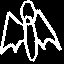

In [17]:
json_to_img(drawing)

In [18]:
# Fetch some images + shuffle order.
n_per_class = 10000
drawings_matrix = [loadn(name, n_per_class) for name in classes]
drawings_list = functools.reduce(lambda x, y: x + y, drawings_matrix, [])
np.random.seed(1)
drawings_list = np.random.permutation(drawings_list)

# Quick test to see how our code works so far
draw_strokes(drawings_list[0]['drawing'])
print(str(drawings_list[0]['word']))

zebra


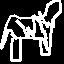

In [19]:
json_to_img(drawings_list[0]['drawing'])

# Save a dataset to disk

In [20]:
X, y = [], []
for drawing in drawings_list:
  X.append(np.array(json_to_img(drawing['drawing'])))
  y.append(str(drawing['word']))
  
dataset_path = 'mini-quickdraw.npz'
out = open(dataset_path, 'w')
np.savez_compressed(out, X, y, X=X, y=y)

In [21]:
# Demonstrate loading
loaded = np.load(open(dataset_path))
X, y = loaded["X"], loaded["y"]
print(X.shape, y.shape)

(430000, 64, 64) (430000,)


zebra


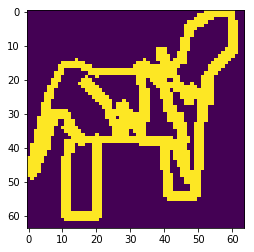

In [26]:
plt.imshow(X[0])
print(y[0])